<a href="https://colab.research.google.com/github/hvarS/CS60075-Team28-Task-1/blob/harshvardhan/experimentation_with_bilstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Important Libraries and Installing HuggingFace

In [ ]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers


     |████████████████████████████████| 1.9MB 8.3MB/s 
     |████████████████████████████████| 3.2MB 34.8MB/s 
     |████████████████████████████████| 890kB 50.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=0823dc2c065ae5ff3cad8a4cdb9d811f1e87e704cbd2961e3500dae40d55be0c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import numpy as np


In [ ]:
df = pd.read_csv("lcp_single_train_preprocessed.tsv")

In [ ]:
print("No of training Sentences  = ",df.shape[0])

No of training Sentences  =  7662


In [ ]:
cols = df.columns

In [ ]:
df.head(3)

,id,corpus,sentence,token,start,end,binary,complexity
0,3ZLW647WALVGE8EBR50EGUBPU4P32A,bible,bible behold came river seven cattle sleek fat...,river,18,23,0.0,0.00
1,34R0BODSP1ZBN3DVY8J8XSIY551E5C,bible,bible fellow bondservant brother prophet keep ...,brother,25,32,0.0,0.00
2,3S1WOPCJFGTJU2SGNAN2Y213N6WJE3,bible,bible man lord land said u know honest men lea...,brother,53,60,0.0,0.05


In [ ]:
starts = []
ends = []
bin = []
for i in range(len(df)):
  sentence = df['sentence'][i]
  word = str(df['token'][i])
  if df['complexity'][i]<0.5:
    bin.append(0.0)
  else:
    bin.append(1.0)
  start_index = sentence.find(word)
  end_index = start_index + len(word)
  starts.append(start_index)
  ends.append(end_index)
df.insert(4, "start",starts, True) 
df.insert(5,"end",ends,True)
df.insert(6,"binary",bin,True)
  

Trying out different route ##START

_______________________________________

Downloading Glove Embeddings :

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-03-02 08:14:17--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-02 08:14:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-02 08:14:18--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove.6B.zip -d embeddings

Archive:  glove.6B.zip
  inflating: embeddings/glove.6B.50d.txt  
  inflating: embeddings/glove.6B.100d.txt  
  inflating: embeddings/glove.6B.200d.txt  
  inflating: embeddings/glove.6B.300d.txt  


In [ ]:
Model = namedtuple('Model', 'type, name, dimension, corpus, model')
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'embeddings/'


glove_models = []

glove_defs = [ Model('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None)]
              
for model in glove_defs:
    glove_file = MAIN_PATH + model.name
    tmp_file = get_tmpfile(model.name + '-temp')
    glove2word2vec(glove_file, tmp_file)
    vecs = KeyedVectors.load_word2vec_format(tmp_file)
    glove_models.append(Model(model.type, model.name, model.dimension, model.corpus, vecs))
    print('load model : {}'.format(model.name))
    
print(glove_models)

load model : glove.6B.300d.txt
[Model(type='glove', name='glove.6B.300d.txt', dimension=300, corpus='wikipedia+gigaword5', model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x7fdacb18d910>)]


In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from nltk import word_tokenize
from functools import lru_cache
import re
import unicodedata
import sys
from collections import Counter
import nltk
nltk.download('brown')
from nltk.corpus import brown
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(tbl)

@lru_cache(maxsize=None)
def all_tokens_with_index(context):
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    return [val for val in targets if val[0] != '"']




In [ ]:
def build_vocabulary(sentences, embedding_model, dimension):
    all_words = [tpl[0] for sentence in sentences for tpl in sentence['seq']] + list(wordlist_lowercased)
    print('# Words : {}'.format(len(all_words)))
    counter = Counter(all_words)
    vocab_size = len(counter) + 1
    print('# Vocab : {}'.format(vocab_size))
    print('# embeding model  : {}'.format(len(embedding_model.vocab)))   
    word2index = {word : index for index, (word, count) in enumerate(counter.most_common(), 1)}
    index2word = {index : word for word, index in word2index.items()}
    # +1 required for pad token
    embedding_matrix = np.zeros(((vocab_size), dimension))
    missing_embed_words = []
    i_ = 0
    for word, index in word2index.items():
        if word in embedding_model.vocab:
            embedding = embedding_model[word]
        else:
             i_ +=1
             continue
        embedding_matrix[index] = embedding
    missing_embed_count = len(missing_embed_words)
    print('# Words missing embedding : {}'.format(missing_embed_count))
    print('Embedding shape : {}'.format(embedding_matrix.shape))
    print("i: ", i_ )
    return word2index, index2word, embedding_matrix



In [ ]:
def forward_transformation(dataframe, lowercase = True, filter_punc = True, filtering = "a132"):
    grouped = dataframe.groupby('sentence').apply(lambda row : 
                        {'sent_id' : list(set(row['id']))[0],
                         'sentence' : list(set(row['sentence']))[0], 
                         'tags': [tag for tag in zip(row['token'], 
                            row['start'], row['end'], row['binary'], row['complexity'])]})

    sentences = []
    for vals in grouped:
        sent_id = vals['sent_id']
        sentence = vals['sentence']
        tags = vals['tags']
        tags_without_labels = [(word, start, end) for word, start, end, binary, prob in tags]
        all_tokens = all_tokens_with_index(sentence)
        sent_repr = [(word, start, end, tags[tags_without_labels.index((word, start, end))][3],
                     tags[tags_without_labels.index((word, start, end))][4])
           if (word, start, end) in tags_without_labels 
          else (word, start, end, 0, 0.0) for word, index, start, end in all_tokens]
        if lowercase:
            sent_repr = [(word.lower(), start, end, binary, prob) 
                         for word, start, end, binary, prob in sent_repr]
        if filter_punc:
            sent_repr = list(filter(lambda vals : remove_punctuation(vals[0]), sent_repr))
        if filtering:
            sent_repr = list(filter(lambda vals : vals[0] != "'s", sent_repr))
            sent_repr = list(filter(lambda vals : vals[0] != "``", sent_repr))
        sentences.append({'sent_id' : sent_id, 'sentence' : sentence, 'seq' : sent_repr})
    return sentences


In [ ]:
def split_sentence_seqs(sentences):
    words, start_end, binary, prob = [], [], [] ,[]
    for sent in sentences:
        sequence = sent['seq']
        curr_w, curr_se, curr_b, curr_p = map(list, zip(*[(vals[0], 
            (vals[1], vals[2]), vals[3], vals[4]) for vals in sequence]))
        words.append(curr_w)
        start_end.append(curr_se)
        binary.append(curr_b)
        prob.append(curr_p)
    return words, start_end, binary, prob

In [ ]:
sentences = forward_transformation(df)
train_sentences = sentences[:int(len(df)*0.8-1)]
test_sentences = sentences[int(len(df)*0.8):]

In [ ]:
sentences

[{'sent_id': '3D06DR5225J65XHPA2Y8IB3T6JGMAY',
  'sentence': 'bible aaron shall make atonement horn year blood sin offering atonement year shall make atonement throughout generation',
  'seq': [('bible', 0, 5, 0, 0.0),
   ('aaron', 6, 11, 0, 0.0),
   ('shall', 12, 17, 0, 0.0),
   ('make', 18, 22, 0, 0.0),
   ('atonement', 23, 32, 0, 0.0),
   ('horn', 33, 37, 0.0, 0.3157894736842105),
   ('year', 38, 42, 0, 0.0),
   ('blood', 43, 48, 0, 0.0),
   ('sin', 49, 52, 0, 0.0),
   ('offering', 53, 61, 0, 0.0),
   ('atonement', 62, 71, 0, 0.0),
   ('year', 72, 76, 0, 0.0),
   ('shall', 77, 82, 0, 0.0),
   ('make', 83, 87, 0, 0.0),
   ('atonement', 88, 97, 0, 0.0),
   ('throughout', 98, 108, 0, 0.0),
   ('generation', 109, 119, 0, 0.0)]},
 {'sent_id': '3IWA71V4TIGGC74QYWJ5DNH5H6HX6E',
  'sentence': 'bible aaron shall present bull sin offering shall make atonement house shall kill bull sin offering',
  'seq': [('bible', 0, 5, 0, 0.0),
   ('aaron', 6, 11, 0, 0.0),
   ('shall', 12, 17, 0, 0.0),
   (

In [ ]:
words, start_end, binary, prob = split_sentence_seqs(sentences)

## sentence_tokenized is a list of dictionaries, with key1 = sentence(actual) and key2 = the tokens obtained for the above sentence , key3 = target word and key4 = its complexity score

In [ ]:
wordlist_lowercased = set(i.lower() for i in brown.words())
print (len(wordlist_lowercased))

49815


In [ ]:
sentence_lens = [len(sent) for sent in words]

In [ ]:
embedding_model = glove_models[0].model
dimension = embedding_model.vector_size
word2index, index2word, embedding = build_vocabulary(sentences, embedding_model, dimension)

# Words : 153572
# Vocab : 56029
# embeding model  : 400000
# Words missing embedding : 0
Embedding shape : (56029, 300)
i:  11927


# Padding the Input Sequences to get the binary labels 

In [ ]:
words_with_indices = [[word2index[word] for word in sent] for sent in words]
sent_lens = [len(sentence['seq']) for sentence in sentences]
sent_max_length = np.max(sent_lens)
print('Max length sentence : {}'.format(sent_max_length))

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

words_padded = pad_sequences(maxlen=sent_max_length, sequences=words_with_indices, padding="post", value=0)
binary_padded = pad_sequences(maxlen=sent_max_length, sequences=binary, padding="post", value=0)
prob_padded = pad_sequences(maxlen=sent_max_length, sequences=prob, padding="post", value=0, dtype="float")

binary_padded_categorical = [to_categorical(clazz, num_classes=2) for clazz in binary_padded]


Max length sentence : 124


Train - Test Split

In [ ]:
train_words_padded = words_padded[:int(len(df)*0.8-1)]
train_binary_padded = binary_padded[:int(len(df)*0.8-1)]
train_binary_padded_categorical = binary_padded_categorical[:int(len(df)*0.8-1)]
train_prob_padded = prob_padded[:int(len(df)*0.8-1)]
train_start_end = start_end[:int(len(df)*0.8-1)]

# (2) Test set
test_words_padded = words_padded[int(len(df)*0.8):]
test_binary_padded = binary_padded[int(len(df)*0.8):]
test_binary_padded_categorical = binary_padded_categorical[int(len(df)*0.8):]
test_prob_padded = prob_padded[int(len(df)*0.8):]
test_start_end = start_end[int(len(df)*0.8):]

print('Training set length : {}'.format(len(train_words_padded)))
print('Test set length : {}'.format(len(test_words_padded)))

Training set length : 6128
Test set length : 686


In [ ]:
from keras.models import Model, Input
from keras import backend as K
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

vocab_size = embedding.shape[0]
dimension = embedding.shape[1]

np.set_printoptions(threshold=np.inf)

in_seq = Input(shape=(sent_max_length,))
embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
drop = Dropout(0.1)(embed)
lstm = Bidirectional(LSTM(units=150, return_sequences=True, recurrent_dropout=0.1))(drop)
out = TimeDistributed(Dense(2, activation="softmax"))(lstm) 

model = Model(in_seq, out)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

metrics = Metrics((test_words_padded, np.array(test_binary_padded_categorical)))

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 124)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 124, 300)          16808700  
_________________________________________________________________
dropout (Dropout)            (None, 124, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 124, 300)          541200    
_________________________________________________________________
time_distributed (TimeDistri (None, 124, 2)            602       
Total params: 17,350,502
Trainable params: 17,350,502
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_words_padded, np.array(train_binary_padded_categorical), batch_size=10, 
                    epochs=3, validation_data = (test_words_padded, np.array(test_binary_padded_categorical)), 
                    verbose=1, callbacks=[metrics])


Epoch 1/3
613/613 [==============================] - 511s 825ms/step - loss: 0.0399 - accuracy: 0.9926 - val_loss: 0.0025 - val_accuracy: 0.9993

F1 Score:
0.0008695549993537092
Epoch 2/3
613/613 [==============================] - 512s 836ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.0021 - val_accuracy: 0.9996

F1 Score:
0.0008695549993537092
Epoch 3/3
613/613 [==============================] - 518s 845ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.0024 - val_accuracy: 0.9995

F1 Score:
0.0008695549993537092


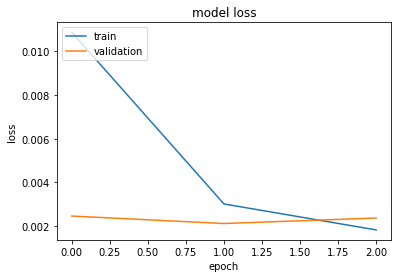

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

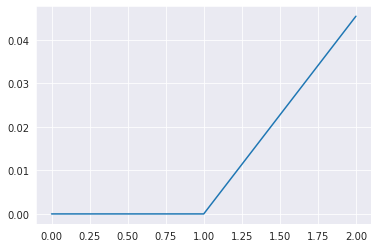

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")
epoch_f1s = plt.plot(metrics.f1_scores)
plt.show()


Keras Callback to Validate on Train

In [ ]:

from sklearn.metrics import f1_score
import keras.callbacks
from keras import backend as K
class Metrics(keras.callbacks.Callback):
    def __init__(self, validation_data):
        self.f1_scores = []
        self.validation_data = validation_data
        
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        targ = self.validation_data[1]
        targ = np.array(targ)
        shape = targ.shape
        targ = targ.reshape((shape[0]*shape[1], shape[2]))
        targ = np.argmax(targ, axis = 1)
        predict = predict.reshape((shape[0]*shape[1]), shape[2])
        predict = np.argmax(predict, axis = 1)
        self.f1s=f1_score(targ, predict)
        print("\nF1 Score:")
        print(f1_score(targ, np.ones(shape[0]*shape[1])))
        self.f1_scores.append(self.f1s)
        return

In [ ]:
stop_words_ = set(stopwords.words('english'))
def cleaner(word):
  #Remove links
  word = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*', 
                '', word, flags=re.MULTILINE)
  word = re.sub('[\W]', ' ', word)
  word = re.sub('[^a-zA-Z]', ' ', word)
  return word.lower().strip()


In [ ]:
def process_input(input_text):
  input_text = cleaner(input_text)
  clean_text = []
  index_list =[]
  input_token = []
  index_list_zipf = []
  for i, word in enumerate(input_text.split()):
    if word in word2index:
      clean_text.append(word)
      input_token.append(word2index[word])
    else:
      index_list.append(i)
  input_padded = pad_sequences(maxlen=sent_max_length, sequences=[input_token], padding="post", value=0)
  return input_padded, index_list, len(clean_text)

Training 

In [ ]:
def complete_missing_word(pred_binary, index_list, len_list):
  list_cwi_predictions = list(pred_binary[0][:len_list])
  for i in index_list:
    list_cwi_predictions.insert(i, 0)
  return list_cwi_predictions


Trying out Different Route ##END

In [ ]:
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM

bert_model = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(bert_model)
model = BertForMaskedLM.from_pretrained(bert_model)
model.eval()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, elementw

In [ ]:
!pip install wordfreq

     |████████████████████████████████| 36.4MB 77kB/s 
     |████████████████████████████████| 174kB 52.3MB/s 
     |████████████████████████████████| 727kB 50.1MB/s 
  Created wheel for wordfreq: filename=wordfreq-2.4.2-cp37-none-any.whl size=36384934 sha256=8ad59187de75456ee269a46099e94ed08775aede2a19d515fc14b11af015d34d
  Stored in directory: /root/.cache/pip/wheels/be/7f/2f/ce0b9835ee84fc6b392b1e4563c77270c39a6882e74d22373b
  Created wheel for langcodes: filename=langcodes-3.1.0-cp37-none-any.whl size=165888 sha256=d97f65ea10e36826ee346e5e96acce23b873673cfb1efd6689f79b962d2348a6
  Stored in directory: /root/.cache/pip/wheels/78/57/10/167a0f1c07409a7b72d8d08391fa9739ef37e834695575ccc8
Successfully built wordfreq langcodes
  Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20


In [ ]:
def get_bert_candidates(input_text, list_cwi_predictions, numb_predictions_displayed = 10):
  list_candidates_bert = []
  for word,pred  in zip(input_text.split(), list_cwi_predictions):
    if (pred and (pos_tag([word])[0][1] in ['NNS', 'NN', 'VBP', 'RB', 'VBG','VBD' ]))  or (zipf_frequency(word, 'en')) <3.1:
      replace_word_mask = input_text.replace(word, '[MASK]')
      text = f'[CLS]{replace_word_mask} [SEP] {input_text} [SEP] '
      tokenized_text = tokenizer.tokenize(text)
      masked_index = [i for i, x in enumerate(tokenized_text) if x == '[MASK]'][0]
      indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
      segments_ids = [0]*len(tokenized_text)
      tokens_tensor = torch.tensor([indexed_tokens])
      segments_tensors = torch.tensor([segments_ids])
      # Predict all tokens
      with torch.no_grad():
          outputs = model(tokens_tensor, token_type_ids=segments_tensors)
          predictions = outputs[0][0][masked_index]
      predicted_ids = torch.argsort(predictions, descending=True)[:numb_predictions_displayed]
      predicted_tokens = tokenizer.convert_ids_to_tokens(list(predicted_ids))
      list_candidates_bert.append((word, predicted_tokens))
  return list_candidates_bert

_________________________________________________________

We have got sentences, tokens and their corresponding scores as vector till now  

Now we start adding tokenisation , attention masks and padding to the sentences so that the BERT model gets the input in the required format 

# Tokenisation

 Loading the BERT tokenizer ....
 Loaded the tokenizer .


[101, 6331, 27541, 2234, 2314, 2698, 7125, 21185, 6638, 7349, 9409, 5568, 102]

input_encoded_sentences Contains the encoded mapping of the sentences to be used in the training .

## **Padding**

90 % Percentile : 39.0
95 % Percentile : 47.0
99 % Percentile : 65.0
Max sentence length =  238


Since the 99% percentile is <= 65 length of encoded length , we can use MAX_LEN = 64 in future to for quicker training , i.e only 7-10 sentences will not be included in the training process 


Padding/truncating all sentences to 256 values...

Padding token: "[PAD]", ID: 0
Done.


# ***Attention Masks***